In [1]:
import pandas as pd
import upsetplot
from functools import reduce
from itertools import combinations
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.patches as mpatches
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 7, 'axes.linewidth': 1, 'xtick.major.width': 1, 'xtick.major.size': 5, 'ytick.major.width': 1, 'ytick.major.size': 5})
from matplotlib.backends.backend_pdf import PdfPages

import itertools as it
import venn

In [2]:
bmi_cat_df = pd.read_excel(
    "../data/manual_lit/monogenic_lit_review.xlsx", 
    usecols=["gene", "rvas", "gwas", "CMDKP", "pubmed_hits_max50", "impc"]
    )

In [3]:
bmi_cat_df["pubmed_hits_max50"] = bmi_cat_df.pubmed_hits_max50>0

In [4]:
study_genes = set(bmi_cat_df.gene)
rvas_genes = set(bmi_cat_df.loc[bmi_cat_df.rvas==True, "gene"])
gwas_genes = set(bmi_cat_df.loc[bmi_cat_df.gwas==True, "gene"])
cmdkp_genes = set(bmi_cat_df.loc[bmi_cat_df.CMDKP==True, "gene"])
impc_genes = set(bmi_cat_df.loc[bmi_cat_df.impc==True, "gene"])
pubmed_genes = set(bmi_cat_df.loc[bmi_cat_df.pubmed_hits_max50==True, "gene"])
protein_genes = set(["GLOD4", "MMP3", "FGF2", "ROBO1", "DNER", "CD27"])

In [5]:
len(reduce(lambda x,y: x.union(y), [rvas_genes, gwas_genes, cmdkp_genes, impc_genes, pubmed_genes, protein_genes]))

87

In [6]:
    
def get_genes_df(g, gl):
    df = pd.DataFrame(g, columns=["gene"])
    df["label"] = gl
    return df

def get_intersecting_num(gene_sets, prod):
    sign = [-1 if p==0 else 1 for p in prod]
    sign_dict = {idx: s for idx,s in zip(range(len(prod)), sign)}
    # get the positive signs first
    sign_dict = dict(sorted(sign_dict.items(), key=lambda item:item[1], reverse=True))
    for i, (k,v) in enumerate(sign_dict.items()):
        if i == 0:
            assert v==1
            final_set = gene_sets[k]
        else:
            if v==-1:
                final_set = final_set.difference(gene_sets[k])
            else:
                assert v==1
                final_set = final_set.intersection(gene_sets[k])
    return len(final_set)

def create_gene_sets_for_venn(genes, labels):
    genes_df = pd.concat([get_genes_df(g,gl) for g,gl in zip(genes, labels)])
    genes_dict = genes_df.groupby("label").agg({"gene": lambda x: set(x)}).to_dict()["gene"]
    gene_labels, gene_sets = list(genes_dict.keys()), list(genes_dict.values())

    subset_dict = dict()
    for prod in list(it.product([0, 1], repeat=len(labels))):
        if all(p == 0 for p in prod):
            continue
        else:
            subset_dict["".join(list(map(str, prod)))] = get_intersecting_num(gene_sets, prod)
    # gene_labels_colors_dict = {"combinations": "#524FA1", "gwas": "#F68B1F", "mgi": "#D1DE76", "previous studies": "#BC668B"}
    # colors=[gene_labels_colors_dict[gl] for gl in gene_labels]
    default_colors = [
        # r, g, b, a
        [82, 79, 161, 0.5], #[90, 155, 212, 0.5],
        [246, 139, 31, 0.5],#[241, 90, 96, 0.4],
        [209, 222, 118, 0.3], #[92, 192, 98, 0.5],
        [188, 102, 139, 0.2], #[82, 82, 190, 0.2],
        [246, 236, 86, 0.6],
        [255, 117, 0, 0.3],
    ]
    default_colors = [
        [i[0] / 255.0, i[1] / 255.0, i[2] / 255.0, i[3]]
        for i in default_colors
    ]
    fig, ax = venn.venn5(subset_dict, names=gene_labels, colors=default_colors, figsize=(6, 6))
    return fig, genes_dict

In [7]:
def set_add(a, b):
    return a.intersection(b)

def set_subtract(a,b):
    return a.difference(b)

def get_intersects(include_sets, exclude_sets):
    intersect_sets = reduce(set_add, include_sets)
    if len(exclude_sets)>0:
        exclude_sets = [intersect_sets] + exclude_sets
        intersect_sets = reduce(set_subtract, exclude_sets)
    return intersect_sets

def get_upset_df(combo_dict, groups):
    # get the set of gene combinations for each group
    combo_boolean_dict = {g:[] for g in groups}
    counts = []
    unique_intersect_sets = dict()
    for i in range(1, len(groups) + 1):
        # get combinations of length i
        all_combos = list(combinations(groups, i))
        for combos in all_combos:
            # get counts of elements that are unique to the combinations
            include_combos = combos
            exclude_combos = tuple(g for g in groups if g not in include_combos)
            include_sets = [combo_dict[c] for c in include_combos]
            exclude_sets = [combo_dict[c] for c in exclude_combos]
            unique_intersects = get_intersects(include_sets, exclude_sets)
            counts.append(len(unique_intersects))
            unique_intersect_sets[(include_combos, exclude_combos)] = unique_intersects
            for c in include_combos:
                combo_boolean_dict[c].append(True)
            for c in exclude_combos:
                combo_boolean_dict[c].append(False)
    combo_boolean_dict["counts"] = counts
    df = pd.DataFrame(combo_boolean_dict)
    return df.set_index(groups), unique_intersect_sets

In [8]:
gene_dict = {
    "gwas": gwas_genes, "rvas": rvas_genes, "cmdkp": cmdkp_genes, "impc": impc_genes, "pubmed": pubmed_genes
    }

In [9]:
upset_df, unique_intersects = get_upset_df(gene_dict, ["gwas", "rvas", "cmdkp", "impc", "pubmed"])

In [10]:
parsed_upset_df = upset_df.loc[upset_df.counts>0]

In [11]:
import upsetplot

(0.0, 1.0, 0.0, 1.0)

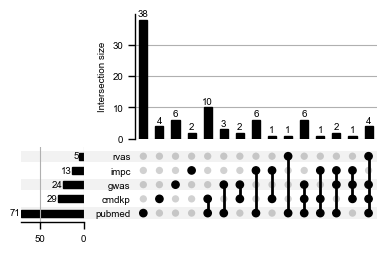

In [12]:
fig,ax = plt.subplots(1,1, figsize=(4, 4))
upsetplot.plot(parsed_upset_df.counts, show_counts=True, element_size=15, intersection_plot_elements=8, totals_plot_elements=4, fig=fig)

ax.axis("off")

In [13]:
def save_pdf(save_file, fig):
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight',dpi=300)
    pdf.close()
    return

In [14]:
save_pdf("../data/manual_lit/upset.pdf", fig)

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

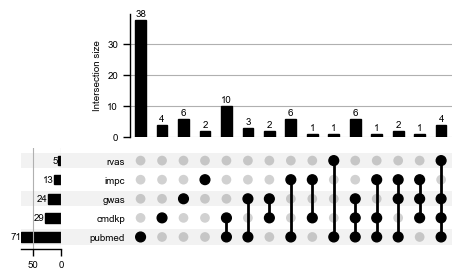

In [75]:
upsetplot.plot(parsed_upset_df.counts, show_counts=True, element_size=20, intersection_plot_elements=6, totals_plot_elements=2)

/Users/dzb5732/opt/anaconda3/envs/dnanexus/lib/python3.11/site-packages/venn/_backwards_compatibility.py:30: UserWarning: `venn5()` is retained for backwards compatibility; use `venn()` instead
  warn((


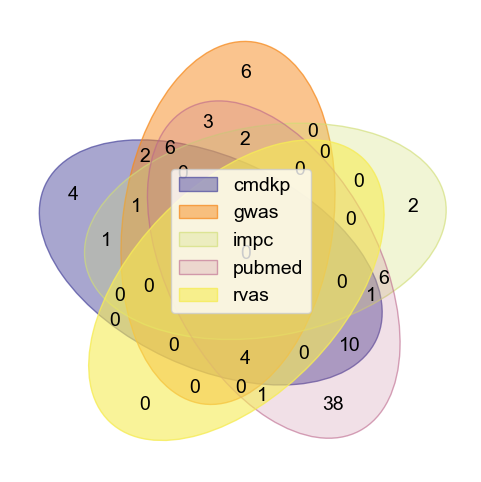

In [23]:
fig, genes_dict = create_gene_sets_for_venn([gwas_genes, rvas_genes, cmdkp_genes, impc_genes, pubmed_genes], ["gwas", "rvas", "cmdkp", "impc", "pubmed"])

In [4]:
rvas_genes = [
    "POMC", "ROBO1", "UBR2", "APBA1", "BSN", "MC4R"
]

gwas_genes = [
    "RABEP1", "VIRMA", "TSPAN4", "IQCF6", "FGF2", "GRXCR1", "MIPEP", 
    "CTBP2", "PML", "ALG8", "PCDHA3", "RORA", "PAM", "POMC", "DNER", 
    "JPH3", "DCP1B", "NCOR1", "MACROD1", "LONRF2", "ROBO1", "UBR2", 
    "BSN", "MC4R"
]

cmdkp_genes = [
    "ZNF627", "COLEC11", "RASSF3", "LAMB2", "SETX", "PI4KB", "AHNAK",
    "FARP2", "CYP3A5", "NALCN", "ABCA1", "CELSR3", "SBF2", "SUPT5H", 
    "SLC43A2", "ANGPT2"
]

impc_genes = [
    "DCUN1D3", "AQP3", "SNAP29", "KCTD7", "SETX", "APMAP", "AHNAK",
    "ALG8", "POMC", "TSPOAP1", "LONRF2", "CD27", "ZFC3H1"
]

mouse_lit_genes = [
    "FGF2", "MTFP1", "UCP3", "APMAP", "MIPEP", "CTBP2", "MMP3", 
    "PML", "ABCA1", "RORA", "SLC25A1", "POMC", "GABRA5", "LPGAT1",
    "CD27", "ANGPT2"
]

protein_genes = ["GLOD4", "MMP3", "FGF2", "ROBO1", "DNER", "CD27"]

In [6]:
len(set(reduce(lambda x,y: x+y, [rvas_genes, gwas_genes, cmdkp_genes, impc_genes, mouse_lit_genes, protein_genes])))

56